In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [2]:
# preparing dataset
with open('/content/drive/MyDrive/Datasets/steering_angle/data.txt','r') as f:
  txt_file=f.read()

In [3]:
file_name=[]
angle=[]

for i in tqdm(txt_file.split('\n')[:-1]):
  file_name.append(i.split(' ')[0])
  angle.append(i.split(' ')[1].split(',')[0])

100%|██████████| 63825/63825 [00:00<00:00, 334131.05it/s]


In [4]:
df=pd.DataFrame({'file_name':file_name,'angle':angle})

In [5]:
df.to_csv('/content/drive/MyDrive/Datasets/steering_angle/data.csv',index=False)

In [6]:
df.sample(5)

,file_name,angle
62659,62659.jpg,29.240000
57424,57424.jpg,-0.610000
11572,11572.jpg,17.549999
13795,13795.jpg,-0.910000
42371,42371.jpg,-2.420000


In [7]:
df.shape

(63825, 2)

In [8]:
# df=df.sample(10000,random_state=42)

In [9]:
df['angle']=df['angle'].astype(np.float32)

In [10]:
df['angle']=df['angle']*np.pi/180

In [11]:
df['angle'].describe()

,angle
count,63825.000000
mean,0.021931
std,0.464325
min,-5.913525
25%,-0.075747
50%,0.026354
75%,0.123220
max,4.408876


<Axes: ylabel='Frequency'>

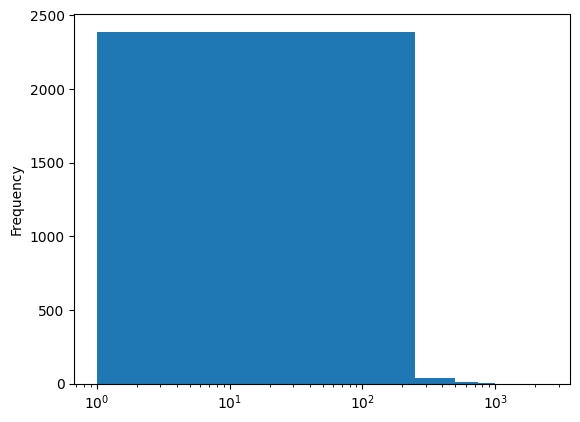

In [12]:
df['angle'].value_counts().plot(kind='hist',logx=True)

<Axes: ylabel='Frequency'>

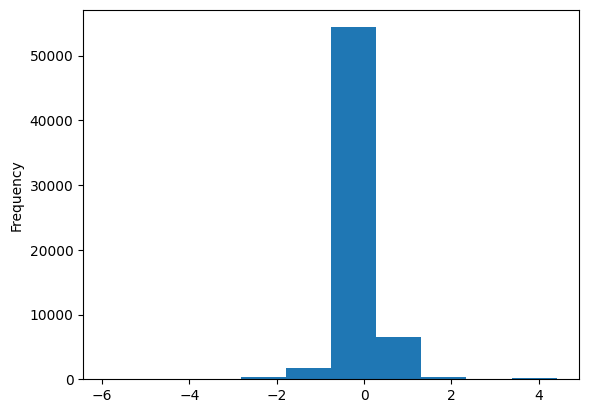

In [13]:
df['angle'].plot(kind='hist')

In [14]:
df['angle'].std()

0.4643249809741974

In [15]:
from sklearn.model_selection import train_test_split

train_df,test_df=train_test_split(df,test_size=0.1,random_state=42)
train_df,val_df=train_test_split(train_df,test_size=0.1,random_state=42)

In [16]:
train_df.shape,val_df.shape,test_df.shape

((51697, 2), (5745, 2), (6383, 2))

# Model

In [17]:
# copying zip files into /content because direct loading from drive is very slow

In [18]:
!mkdir /content/data

In [19]:
!cp /content/drive/MyDrive/Datasets/07012018.zip /content/data.zip

In [20]:
!unzip -q /content/data.zip

In [21]:
# mean_angle=df['angle'].mean()
# std_angle=df['angle'].std()
# df['angle']=(df['angle']-mean_angle)/std_angle

In [22]:
# from tensorflow import keras

# # all images are of shape 455*256 with no duplicates
# input_shape=(256,256,3)
# BATCH_SIZE=64

# # generators
# # The NVIDIA model assumes input pixels are normalized to [−0.5, +0.5].
# train_data_gen=keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function=lambda x: (x / 255.0) - 0.5
# )
# val_data_gen=keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function=lambda x: (x / 255.0) - 0.5
# )
# test_data_gen=keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function=lambda x: (x / 255.0) - 0.5
# )

# train_data_gen=train_data_gen.flow_from_dataframe(train_df,x_col='file_name',y_col='angle',class_mode='raw',directory="/content/data",target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE,seed=42)
# val_data_gen=val_data_gen.flow_from_dataframe(val_df,x_col='file_name',y_col='angle',class_mode='raw',directory="/content/data",target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE,seed=42)
# test_data_gen=test_data_gen.flow_from_dataframe(test_df,x_col='file_name',y_col='angle',class_mode='raw',directory="/content/data",target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE,seed=42)


In [23]:
def augment(img, angle):
    # 50% chance flip
    do_flip = tf.random.uniform([]) > 0.5
    img = tf.cond(do_flip, lambda: tf.image.flip_left_right(img), lambda: img)
    angle = tf.cond(do_flip, lambda: -angle, lambda: angle)
    return img, angle

def augment_w(img, angle, w):
    img, angle = augment(img, angle)
    return img, angle, w


In [24]:
import tensorflow as tf
import cv2
import numpy as np

BATCH_SIZE = 32
IMG_W, IMG_H = 200, 66

def load_image(path, angle):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)

    img = img[-150:, :, :]
    img = tf.image.resize(img, (IMG_H, IMG_W))

    img = (img / 255.0) - 0.5
    return img, angle

def make_dataset(df, shuffle):
    paths = df['file_name'].apply(lambda x: "/content/data/" + x).values
    angles = df['angle'].values.astype(np.float32)

    ds = tf.data.Dataset.from_tensor_slices((paths, angles))
    if shuffle:
        ds = ds.shuffle(5000)
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, shuffle=True)
val_ds   = make_dataset(val_df, shuffle=False)
test_ds  = make_dataset(test_df, shuffle=False)

In [25]:
# model building
from keras.applications import resnet50

# loading without base
base_model=resnet50.ResNet50(weights='imagenet',include_top=False,input_shape=(IMG_H,IMG_W,3))
base_model.trainable=False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [26]:
from sklearn.metrics import r2_score
from tensorflow.keras import backend as K

def cal_r2(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [27]:
# model=keras.Sequential()

# model.add(base_model)

# model.add(keras.layers.Flatten())

# model.add(keras.layers.Dense(128,activation='relu'))
# model.add(keras.layers.Dense(64,activation='relu'))
# model.add(keras.layers.Dense(1,activation='linear'))

# model.compile(optimizer='adam',loss='mse',metrics=['mae','mse',cal_r2])

In [28]:
def atan_activation(x):
    return 2*tf.math.atan(x)

In [30]:
from tensorflow import keras
model=keras.Sequential()
model.add(keras.layers.Input(shape=(IMG_H,IMG_W,3)))

model.add(keras.layers.Conv2D(24,kernel_size=(5,5),strides=(2,2),activation='elu'))

model.add(keras.layers.Conv2D(36,kernel_size=(5,5),strides=(2,2),activation='elu'))

model.add(keras.layers.Conv2D(48,kernel_size=(5,5),strides=(2,2),activation='elu'))

model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='elu'))

model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='elu'))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(1164,activation='relu'))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(50,activation='relu'))
model.add(keras.layers.Dense(1,activation='linear'))

model.compile(optimizer='adam',loss='mae',metrics=['mae','mse'])

In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1164)           │     1,342,092 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │       116,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,595,041 (6.08 MB)

 Trainable params: 1,595,041 (6.08 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

early_stop=EarlyStopping(patience=5,monitor='val_loss',verbose=1)
red_lr=ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1)
check_pt=ModelCheckpoint('sterring_angle.h5',verbose=1,monitor='val_loss',save_best_only=True)

In [34]:
history=model.fit(train_ds,validation_data=val_ds,epochs=30,batch_size=BATCH_SIZE,callbacks=[early_stop,red_lr,check_pt])

Epoch 1/30
1614/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0726 - mae: 0.0726 - mse: 0.0530
Epoch 1: val_loss improved from 0.08381 to 0.08314, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - loss: 0.0726 - mae: 0.0726 - mse: 0.0530 - val_loss: 0.0831 - val_mae: 0.0831 - val_mse: 0.0778 - learning_rate: 0.0010
Epoch 2/30
1614/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0679 - mae: 0.0679 - mse: 0.0452
Epoch 2: val_loss did not improve from 0.08314
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - loss: 0.0679 - mae: 0.0679 - mse: 0.0452 - val_loss: 0.0834 - val_mae: 0.0834 - val_mse: 0.0754 - learning_rate: 0.0010
Epoch 3/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0685 - mae: 0.0685 - mse: 0.0429
Epoch 3: val_loss improved from 0.08314 to 0.07479, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 76s 47ms/step - loss: 0.0685 - mae: 0.0685 - mse: 0.0429 - val_loss: 0.0748 - val_mae: 0.0748 - val_mse: 0.0627 - learning_rate: 0.0010
Epoch 4/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0640 - mae: 0.0640 - mse: 0.0339
Epoch 4: val_loss did not improve from 0.07479
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 78s 44ms/step - loss: 0.0640 - mae: 0.0640 - mse: 0.0339 - val_loss: 0.0761 - val_mae: 0.0761 - val_mse: 0.0562 - learning_rate: 0.0010
Epoch 5/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0605 - mae: 0.0605 - mse: 0.0303
Epoch 5: val_loss improved from 0.07479 to 0.07066, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 76s 47ms/step - loss: 0.0605 - mae: 0.0605 - mse: 0.0303 - val_loss: 0.0707 - val_mae: 0.0707 - val_mse: 0.0538 - learning_rate: 0.0010
Epoch 6/30
1614/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0591 - mae: 0.0591 - mse: 0.0299
Epoch 6: val_loss did not improve from 0.07066
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - loss: 0.0591 - mae: 0.0591 - mse: 0.0299 - val_loss: 0.0735 - val_mae: 0.0735 - val_mse: 0.0595 - learning_rate: 0.0010
Epoch 7/30
1614/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0576 - mae: 0.0576 - mse: 0.0261
Epoch 7: val_loss improved from 0.07066 to 0.06623, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - loss: 0.0576 - mae: 0.0576 - mse: 0.0261 - val_loss: 0.0662 - val_mae: 0.0662 - val_mse: 0.0473 - learning_rate: 0.0010
Epoch 8/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0572 - mae: 0.0572 - mse: 0.0268
Epoch 8: val_loss did not improve from 0.06623
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - loss: 0.0572 - mae: 0.0572 - mse: 0.0269 - val_loss: 0.0710 - val_mae: 0.0710 - val_mse: 0.0594 - learning_rate: 0.0010
Epoch 9/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0564 - mae: 0.0564 - mse: 0.0249
Epoch 9: val_loss improved from 0.06623 to 0.06347, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - loss: 0.0564 - mae: 0.0564 - mse: 0.0249 - val_loss: 0.0635 - val_mae: 0.0635 - val_mse: 0.0517 - learning_rate: 0.0010
Epoch 10/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0545 - mae: 0.0545 - mse: 0.0227
Epoch 10: val_loss improved from 0.06347 to 0.06173, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - loss: 0.0545 - mae: 0.0545 - mse: 0.0227 - val_loss: 0.0617 - val_mae: 0.0617 - val_mse: 0.0373 - learning_rate: 0.0010
Epoch 11/30
1614/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0543 - mae: 0.0543 - mse: 0.0205
Epoch 11: val_loss did not improve from 0.06173
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 76s 47ms/step - loss: 0.0543 - mae: 0.0543 - mse: 0.0205 - val_loss: 0.0642 - val_mae: 0.0642 - val_mse: 0.0506 - learning_rate: 0.0010
Epoch 12/30
1614/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0526 - mae: 0.0526 - mse: 0.0201
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 12: val_loss did not improve from 0.06173
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - loss: 0.0526 - mae: 0.0526 - mse: 0.0201 - val_loss: 0.0669 - val_mae: 0.0669 - val_mse: 0.0389 - learning_rate: 0.0010
Epoch 13/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0453 - mae: 0.0453 - mse: 0.0163
Epoch 13: val_loss improved

1616/1616 ━━━━━━━━━━━━━━━━━━━━ 80s 45ms/step - loss: 0.0453 - mae: 0.0453 - mse: 0.0163 - val_loss: 0.0507 - val_mae: 0.0507 - val_mse: 0.0297 - learning_rate: 1.0000e-04
Epoch 14/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0373 - mae: 0.0373 - mse: 0.0114
Epoch 14: val_loss improved from 0.05073 to 0.04673, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - loss: 0.0373 - mae: 0.0373 - mse: 0.0114 - val_loss: 0.0467 - val_mae: 0.0467 - val_mse: 0.0244 - learning_rate: 1.0000e-04
Epoch 15/30
1614/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0342 - mae: 0.0342 - mse: 0.0092
Epoch 15: val_loss did not improve from 0.04673
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - loss: 0.0342 - mae: 0.0342 - mse: 0.0092 - val_loss: 0.0470 - val_mae: 0.0470 - val_mse: 0.0261 - learning_rate: 1.0000e-04
Epoch 16/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0323 - mae: 0.0323 - mse: 0.0091
Epoch 16: val_loss improved from 0.04673 to 0.04463, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 72s 44ms/step - loss: 0.0323 - mae: 0.0323 - mse: 0.0091 - val_loss: 0.0446 - val_mae: 0.0446 - val_mse: 0.0229 - learning_rate: 1.0000e-04
Epoch 17/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0302 - mae: 0.0302 - mse: 0.0080
Epoch 17: val_loss improved from 0.04463 to 0.04300, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - loss: 0.0302 - mae: 0.0302 - mse: 0.0080 - val_loss: 0.0430 - val_mae: 0.0430 - val_mse: 0.0208 - learning_rate: 1.0000e-04
Epoch 18/30
1614/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0294 - mae: 0.0294 - mse: 0.0083
Epoch 18: val_loss did not improve from 0.04300
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - loss: 0.0294 - mae: 0.0294 - mse: 0.0083 - val_loss: 0.0435 - val_mae: 0.0435 - val_mse: 0.0227 - learning_rate: 1.0000e-04
Epoch 19/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0275 - mae: 0.0275 - mse: 0.0069
Epoch 19: val_loss improved from 0.04300 to 0.04155, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - loss: 0.0275 - mae: 0.0275 - mse: 0.0069 - val_loss: 0.0416 - val_mae: 0.0416 - val_mse: 0.0199 - learning_rate: 1.0000e-04
Epoch 20/30
1614/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0269 - mae: 0.0269 - mse: 0.0069
Epoch 20: val_loss improved from 0.04155 to 0.04099, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - loss: 0.0269 - mae: 0.0269 - mse: 0.0069 - val_loss: 0.0410 - val_mae: 0.0410 - val_mse: 0.0193 - learning_rate: 1.0000e-04
Epoch 21/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0259 - mae: 0.0259 - mse: 0.0064
Epoch 21: val_loss did not improve from 0.04099
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 98s 61ms/step - loss: 0.0259 - mae: 0.0259 - mse: 0.0064 - val_loss: 0.0415 - val_mae: 0.0415 - val_mse: 0.0205 - learning_rate: 1.0000e-04
Epoch 22/30
1614/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0253 - mae: 0.0253 - mse: 0.0065
Epoch 22: val_loss improved from 0.04099 to 0.04036, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 78s 48ms/step - loss: 0.0253 - mae: 0.0253 - mse: 0.0065 - val_loss: 0.0404 - val_mae: 0.0404 - val_mse: 0.0192 - learning_rate: 1.0000e-04
Epoch 23/30
1614/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0248 - mae: 0.0248 - mse: 0.0060
Epoch 23: val_loss improved from 0.04036 to 0.04024, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - loss: 0.0248 - mae: 0.0248 - mse: 0.0060 - val_loss: 0.0402 - val_mae: 0.0402 - val_mse: 0.0196 - learning_rate: 1.0000e-04
Epoch 24/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0241 - mae: 0.0241 - mse: 0.0064
Epoch 24: val_loss improved from 0.04024 to 0.04009, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 84s 47ms/step - loss: 0.0241 - mae: 0.0241 - mse: 0.0064 - val_loss: 0.0401 - val_mae: 0.0401 - val_mse: 0.0192 - learning_rate: 1.0000e-04
Epoch 25/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0233 - mae: 0.0233 - mse: 0.0056
Epoch 25: val_loss improved from 0.04009 to 0.03951, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - loss: 0.0233 - mae: 0.0233 - mse: 0.0056 - val_loss: 0.0395 - val_mae: 0.0395 - val_mse: 0.0197 - learning_rate: 1.0000e-04
Epoch 26/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0231 - mae: 0.0231 - mse: 0.0054
Epoch 26: val_loss improved from 0.03951 to 0.03876, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - loss: 0.0231 - mae: 0.0231 - mse: 0.0054 - val_loss: 0.0388 - val_mae: 0.0388 - val_mse: 0.0191 - learning_rate: 1.0000e-04
Epoch 27/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0226 - mae: 0.0226 - mse: 0.0054
Epoch 27: val_loss did not improve from 0.03876
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - loss: 0.0226 - mae: 0.0226 - mse: 0.0054 - val_loss: 0.0396 - val_mae: 0.0396 - val_mse: 0.0206 - learning_rate: 1.0000e-04
Epoch 28/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0223 - mae: 0.0223 - mse: 0.0058
Epoch 28: val_loss improved from 0.03876 to 0.03839, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - loss: 0.0223 - mae: 0.0223 - mse: 0.0058 - val_loss: 0.0384 - val_mae: 0.0384 - val_mse: 0.0179 - learning_rate: 1.0000e-04
Epoch 29/30
1614/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0219 - mae: 0.0219 - mse: 0.0055
Epoch 29: val_loss improved from 0.03839 to 0.03790, saving model to sterring_angle.h5


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - loss: 0.0219 - mae: 0.0219 - mse: 0.0055 - val_loss: 0.0379 - val_mae: 0.0379 - val_mse: 0.0179 - learning_rate: 1.0000e-04
Epoch 30/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0213 - mae: 0.0213 - mse: 0.0054
Epoch 30: val_loss did not improve from 0.03790
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - loss: 0.0213 - mae: 0.0213 - mse: 0.0054 - val_loss: 0.0381 - val_mae: 0.0381 - val_mse: 0.0198 - learning_rate: 1.0000e-04


<Axes: >

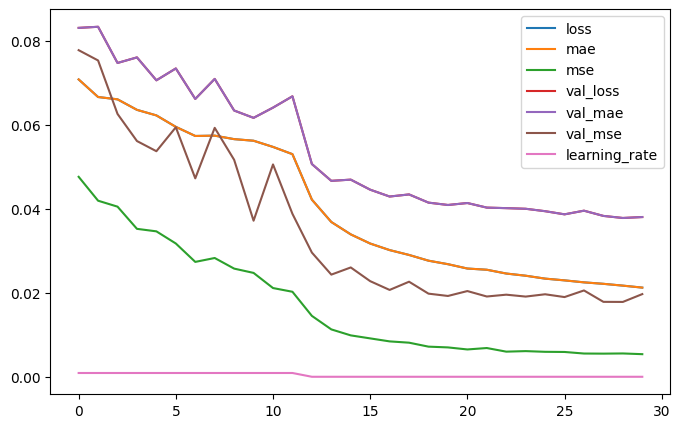

In [35]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [45]:
model.save("sterring_angle.keras")

In [37]:
from tensorflow.keras import models

model=models.load_model('/content/sterring_angle.h5',custom_objects={'mae': 'mean_absolute_error'})

In [38]:
model.evaluate(test_ds)

200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0416 - mean_absolute_error: 0.0416 - mean_squared_error: 0.0258


[0.041137006133794785, 0.041137006133794785, 0.02326396107673645]

In [42]:
import tensorflow
tensorflow.__version__

'2.19.0'